In [84]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import scipy.stats as st
import pickle


from candlestick.candlestick import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from getstock import *

matplotlib.rcParams['figure.figsize'] = (14, 6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data and format it

In [121]:
df_ohlc = pd.read_csv('DAT_MT_USDTRY_M1_201909.csv')
df_ohlc.index = pd.to_datetime(df_ohlc.day)+ pd.to_timedelta(df_ohlc.time.apply(lambda x:x+':00'),unit='minute')
df_ohlc = df_ohlc[['open','high','low','close']]

In [18]:
df_ohlc = pd.read_csv('NASDAQ_AAPL_5min.csv')
df_ohlc.index = pd.to_datetime(df_ohlc.date,format="%Y%m%d%H%M")
df_ohlc = df_ohlc[['open','high','low','close']]

In [29]:
# df_ohlc = pd.read_csv('IBM.1min.TradesAndQuotes.20160128.csv')

# df_ohlc =  df_ohlc[['open','high','low','close']]
# df_ohlc.T

#### Plot Candlestick chart for a short time

In [122]:
df_to_plot = df_ohlc.iloc[:800]
fig = go.Figure(data=[go.Candlestick(x=df_to_plot.index,
                open=df_to_plot['open'],
                high=df_to_plot['high'],
                low=df_to_plot['low'],
                close=df_to_plot['close'])])
fig.show()

#### Define Functions to:
+ Label intervals with returns
+ Detect patterns
+ Make statistics on them

In [123]:
def label(df_candles,n_shift):
    """
    label returns n_shift periods before them
    """
    df_candles['returns'+str(n_shift)] = df_candles['close'].shift(-n_shift)/df_candles['close']
    return df_candles

def get_candlestick_detection_function(pattern):
    return getattr(getattr(__import__('candlestick.candlestick'), 'candlestick'),pattern)

def detect_patterns(patterns_list,df_bars):
    df_bars = df_bars.copy()
    for p in patterns_list:
        func = get_candlestick_detection_function(p)
        df_bars = func(df_bars)
    return df_bars
def make_stats(patterns_list,df_bars,returns_name,confidence=0.95,symbol=None):
    df = pd.DataFrame(index=['mean','CI','count','std','significant'])
    ret = (df_bars[returns_name]-1.)*100
    for p in patterns_list:
        p_list = p.split('_')
        p_modified = ''.join(list(map(lambda x: x[0].upper()+x[1:],p_list)))
        ret_pattern = ret[df_bars[p_modified]==True]
        mean= ret_pattern.mean()
        std = ret_pattern.std()
        count = ret_pattern.count()
        CI = std*st.t.ppf(0.5*(1+confidence),count)/np.sqrt(count)
        significant = (mean+CI)*(mean-CI)>0.
        df[p_modified] = [mean,CI,count,std,significant]
        
    complete_results(symbol,int(returns_name[-1]),df.T)
    return df 

def label_multi(n_shift_list,df_bars):
    df_bars = df_bars.copy()
    for n in n_shift_list:
        df_bars = label(df_bars,n)
    return df_bars



def dump_pickle(obj, path: str, protocol=pickle.HIGHEST_PROTOCOL):
    """
    :param obj: obj to pickle
    :param path: path for the dump MUST BE with no suffix this function will automatically add '.pickle' in the name
    :param protocol: protocol for the pickling
    """
    f = open(path + '.pickle', 'wb')
    try:
        pickle.dump(obj, f, protocol=protocol)
    except Exception as e:
        raise e
    finally:
        f.close()


def load_pickle(path: str):
    """
    Unpickles an objects, returns it and logs before and after the loading
    :param path: str: path for the file to load
    :return: object of the pickle
    """
    # ensuring the file ends in '.pickle'
    path = path.replace('.pickle', '') + '.pickle'

    print('Unpickling data at {}'.format(path))
    f = open(path, 'rb')
    res = pickle.load(f)
    f.close()
    print('Data unpickled, type: {}'.format(res.__class__))
    return res

def complete_results(symbol,n_shift_returns,df_stats):
    path = 'stats_results'
    try:
        dic = load_pickle(path)
    except:
        dic = {}
    
    dic_symbol = dic.get(symbol,{})
    dic_symbol.update({n_shift_returns:df_stats})
    dic.update({symbol:dic_symbol})
    dump_pickle(dic,path)

### Find the list of supported patterns

In [124]:
patterns_list = list(map(lambda x :x.replace('.py',''), os.listdir('candlestick/patterns')))
patterns_list.remove('candlestick_finder')
patterns_list.remove('__pycache__')
patterns_list

['bearish_engulfing',
 'bearish_harami',
 'bullish_engulfing',
 'bullish_harami',
 'dark_cloud_cover',
 'doji',
 'doji_star',
 'dragonfly_doji',
 'evening_star',
 'evening_star_doji',
 'gravestone_doji',
 'hammer',
 'hanging_man',
 'inverted_hammer',
 'morning_star',
 'morning_star_doji',
 'piercing_pattern',
 'rain_drop',
 'rain_drop_doji',
 'shooting_star',
 'star']

#### Run all patterns detection

In [ ]:
df_bars = detect_patterns(patterns_list,df_ohlc)

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji.py:17: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji_star.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\dragonfly_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars



#### Label returns for different shifts

In [ ]:
df_bars = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars)

In [ ]:
df_bars.tail()

#### Statistics on the returns based on the candlestick pattern

In [ ]:
df = make_stats(patterns_list,df_bars,'returns2',confidence=0.95,symbol='USDTRY')
df.T

In [116]:
dic = load_pickle('stats_results.pickle')
dic

Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>


{'EURNOK': {5:                          mean          CI count        std significant
  BearishEngulfing   0.00039846  0.00117787  1979  0.0267181       False
  BearishHarami    -0.000741081  0.00125724  2239  0.0303363       False
  BullishEngulfing  -0.00141718  0.00130444  1908  0.0290528        True
  BullishHarami    -2.74983e-05  0.00121534  2187  0.0289824       False
  DarkCloudCover    -0.00614708   0.0321247    14  0.0560427       False
  Doji              -0.00049642  0.00152805  1732  0.0324235       False
  DojiStar           0.00188779  0.00801654    61  0.0313115       False
  DragonflyDoji    -0.000631595   0.0035739   254  0.0289226       False
  EveningStar      -0.000891331  0.00390136    96  0.0192572       False
  EveningStarDoji    -0.0226379   0.0466865     4  0.0336304       False
  GravestoneDoji   -0.000161786  0.00276756   552  0.0331028       False
  Hammer            -0.00585647  0.00908548   148  0.0559326       False
  HangingMan                NaN       

#### Visualize the distribution of the returns for a specific pattern 

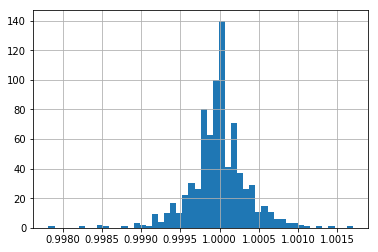

In [65]:
df_bars['returns5'][df_bars['Hammer']==True].hist(bins=50)

#### Resample to larger windows

In [ ]:
df_bars = df_bars.resample('2min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})


## Other way of getting data

First let's take a look at [getstock.py](getstock.py)...

In [130]:
# now let's get some data
# bars = getMinuteFXPrices('EURGBP')
bars = getMinuteStockPrices('EURUSD')